In [2]:
import os
import pandas as pd
from pathlib import Path

Nr 
Panel 
1. 
Copper Indium Gallium Selenide (CIGS), a flexible 
module; 
nominal efficiency Specifications 
12.7% specs 
2. 
Cadmium Telluride (CdTe), a lower cost module; 
12.0% specs 
3. 
Polycrystalline Silicon (Poly-Si), the most commonly 
used technology; 
15.5% specs 
4. 
Interdigitated Back Contact monocrystalline silicon, 
charge extraction located at the back of the cell;  
21.5% specs 
5. 
Heterojunction Intrinsic Layer Monocrystalline Silicon 
(HIT Si), highest lab-tested efficiency; 
19.4% specs 
6. 
Copper Indium Gallium Selenide (CIGS) with reflective 
backing; 
14.7% specs

In [3]:
def get_selected_months(years=None, months=None):
    """
    Generate a list of selected months based on user input for years and months.
    
    Parameters:
        years (list of int): List of years to include (e.g., [2017, 2018]).
        months (list of int): List of months to include (e.g., [1, 2, 3]).
        
    Returns:
        list of str: List of selected year_month combinations (e.g., ['2017_01', '2017_02']).
    """
    if years is None:
        years = [2017]  # Default year
    if months is None:
        months = range(1, 13)  # Default to all months

    selected_months = [f"{year}_{str(month).zfill(2)}" for year in years for month in months]
    return selected_months

In [4]:
def load_and_sync_data(base_path, selected_months, selected_csvs, debug=False):
    base_path = Path(base_path)
    if not base_path.is_dir():
        raise FileNotFoundError(f"The base path does not exist: {base_path}")

    # Dictionary to store DataFrames from each source
    source_dataframes = {}

    for csv_type in selected_csvs:
        combined_source_data = []

        for month in selected_months:
            year, month_number = month.split('_')
            year_folder = f"{year}_V3"
            month_folder = f"{year}_{month_number}"
            month_path = base_path / year_folder / month_folder

            if not month_path.is_dir():
                if debug:
                    print(f"Skipping non-existent directory: {month_path}")
                continue

            # Determine the correct file name for the source
            file_name_with_space = f"{csv_type}- {month_folder}.csv"
            file_name_without_space = f"{csv_type}-{month_folder}.csv"

            file_path = None
            if csv_type == "LightSpectra":
                # Handle LightSpectra's unique naming format
                file_path_with_space = month_path / file_name_with_space
                file_path_without_space = month_path / file_name_without_space
                if file_path_with_space.exists():
                    file_path = file_path_with_space
                elif file_path_without_space.exists():
                    file_path = file_path_without_space
            else:
                file_path = month_path / file_name_without_space

            if file_path and file_path.exists():
                try:
                    data_frame = pd.read_csv(file_path, low_memory=False)

                    # -------------------
                    # Standardize date/time columns
                    # -------------------
                    data_frame["Year"] = data_frame.get("Date[year]", year)
                    data_frame["Month"] = data_frame.get("Date[month]", month_number)
                    data_frame["Day"] = data_frame.get("Date[day]")
                    data_frame["Weekday"] = data_frame.get("Date[weekday]")

                    if "Time[hh:mm:ss]" in data_frame.columns:
                        data_frame["Time"] = data_frame["Time[hh:mm:ss]"]
                        data_frame.drop(columns=["Time[hh:mm:ss]"], errors="ignore", inplace=True)

                    data_frame.drop(
                        columns=[col for col in data_frame.columns if col.startswith("Date[")],
                        errors="ignore",
                        inplace=True
                    )

                    data_frame["Source"] = csv_type  # (optional metadata)
                    combined_source_data.append(data_frame)

                except Exception as e:
                    if debug:
                        print(f"Error loading file {file_path}: {e}")
            else:
                if debug:
                    print(f"File not found: {file_path}")

        # Concatenate all data for the current source
        if combined_source_data:
            source_dataframes[csv_type] = pd.concat(combined_source_data, ignore_index=True)

    # -------------------
    # Merge (inner join) across all sources on "AbsTime[s]"
    # -------------------
    synced_data = None
    for source, df in source_dataframes.items():
        if synced_data is None:
            synced_data = df
        else:
            synced_data = pd.merge(
                synced_data,
                df,
                on='AbsTime[s]',
                how='inner',
                suffixes=('', f'_{source}')
            )

    # -------------------
    # Consolidate duplicate columns
    # -------------------
    if synced_data is not None:
        for col in ["Year", "Month", "Day", "Time", "Weekday"]:
            # Gather all columns that start with "Year", "Month", etc.
            cols_to_merge = [c for c in synced_data.columns if c.startswith(col)]
            if len(cols_to_merge) > 1:
                # Fill "master" col with first non-NaN going left->right
                synced_data[col] = synced_data[cols_to_merge].bfill(axis=1).iloc[:, 0]
                # Drop duplicates except for the original "col"
                cols_to_drop = [c for c in cols_to_merge if c != col]
                synced_data.drop(columns=cols_to_drop, inplace=True, errors="ignore")

        # Remove the "Source" columns if no longer needed
        synced_data.drop(
            columns=[col for col in synced_data.columns if "Source" in col],
            errors="ignore",
            inplace=True
        )

        # Remove exact duplicated columns (rare leftover edge case)
        synced_data = synced_data.loc[:, ~synced_data.columns.duplicated()]

        return synced_data

    # If no data was found at all
    return pd.DataFrame()


if __name__ == "__main__":
    # Base path to the dataset
    base_path = "../../OneDrive - HvA/Jaar_4/PV systems modeling and analysis/Data/data_folder"
    base_path_bono = "../../school/4e jaar/PV systems modeling and analysis/Data/data_folder"

    # Specify months and sources to include
    selected_months = get_selected_months(years=[2017, 2018], months=[1,2,3,4,5,6,7,8,9,10,11,12])
    selected_csvs = ["SolarFieldData"]

    # Load and synchronize data
    synced_df = load_and_sync_data(base_path_bono, selected_months, selected_csvs, debug=True)

    # Display the synchronized DataFrame
    print("\nSynchronized DataFrame:")
    print(synced_df.head())

    # # Save the synchronized data for later use (optional)
    # synced_df.to_csv("synced_data_january_2017_2018.csv", index=False)
    # print("Synchronized data saved to synced_data_january_2017_2018.csv")



Synchronized DataFrame:
   AbsTime[s]  Act Air Density (WeatherStation)  \
0  3692217600                               NaN   
1  3692217900                               NaN   
2  3692218200                               NaN   
3  3692218500                               NaN   
4  3692218800                               NaN   

   Act Wind Direction (WeatherStation)  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

   Act Wind Measurement Quality (WeatherStation)  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   Act Wind Speed [km/h] (WeatherStation)  \
0                                     NaN   
1           

In [5]:
synced_df

,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Clear light (LAD Sensor 12),Infrared light (LAD Sensor 12),Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time
0,3692217600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:00:00
1,3692217900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:05:00
2,3692218200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:10:00
3,3692218500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:15:00
4,3692218800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210235,3755288100,1.267891,302.2157,100.0,2.646927,1032.549,9.585670,5.963782,78.15392,2.154424,...,0.0,0.0,9.0,0.0,192.0,2018,December,31,Monday,23:35:00
210236,3755288400,1.267709,331.9254,100.0,3.448386,1032.489,9.578792,5.832692,77.48536,2.462776,...,0.0,0.0,9.0,0.0,192.0,2018,December,31,Monday,23:40:00
210237,3755288700,1.267387,280.9585,100.0,4.236672,1032.412,9.671638,5.831314,76.99681,2.394305,...,0.0,0.0,9.0,0.0,192.0,2018,December,31,Monday,23:45:00
210238,3755289000,1.267123,300.8190,100.0,2.590765,1032.292,9.670290,5.770670,76.68160,2.708162,...,0.0,0.0,9.2,0.0,192.0,2018,December,31,Monday,23:50:00


In [6]:
# 1) Maandnaam omzetten naar maandnummer
month_map = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}
synced_df['Month_num'] = synced_df['Month'].map(month_map)

# 2) De kolommen Year, Month_num, Day en Time samenvoegen tot een datumstring
synced_df['datetime_str'] = (
    synced_df['Year'].astype(str) + '-' +
    synced_df['Month_num'].astype(str) + '-' +
    synced_df['Day'].astype(str) + ' ' +
    synced_df['Time'].astype(str)
)

# 3) Deze string parsen naar een datetime-kolom
synced_df['datetime'] = pd.to_datetime(synced_df['datetime_str'], format='%Y-%m-%d %H:%M:%S')

# 4) Zet deze nieuwe kolom als index van je DataFrame
synced_df.set_index('datetime', inplace=True)

# 5) (Optioneel) Opruimen: als je de losse kolommen niet meer nodig hebt:
synced_df.drop(columns=['Month_num', 'datetime_str'], inplace=True)

synced_df

,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Clear light (LAD Sensor 12),Infrared light (LAD Sensor 12),Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,3692217600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:00:00
2017-01-01 00:05:00,3692217900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:05:00
2017-01-01 00:10:00,3692218200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:10:00
2017-01-01 00:15:00,3692218500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:15:00
2017-01-01 00:20:00,3692218800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:35:00,3755288100,1.267891,302.2157,100.0,2.646927,1032.549,9.585670,5.963782,78.15392,2.154424,...,0.0,0.0,9.0,0.0,192.0,2018,December,31,Monday,23:35:00
2018-12-31 23:40:00,3755288400,1.267709,331.9254,100.0,3.448386,1032.489,9.578792,5.832692,77.48536,2.462776,...,0.0,0.0,9.0,0.0,192.0,2018,December,31,Monday,23:40:00
2018-12-31 23:45:00,3755288700,1.267387,280.9585,100.0,4.236672,1032.412,9.671638,5.831314,76.99681,2.394305,...,0.0,0.0,9.0,0.0,192.0,2018,December,31,Monday,23:45:00


In [7]:
#"",AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),Precipitation Intensity [mm/h] (WeatherStation),Precipitation Type (WeatherStation),Module #_1 (Solarpanel parameters),Vmpp[V]_1 (Solarpanel parameters),Impp[A]_1 (Solarpanel parameters),Pmpp[W]_1 (Solarpanel parameters),Voc[V]_1 (Solarpanel parameters),Isc[A]_1 (Solarpanel parameters),FF[%]_1 (Solarpanel parameters),G[W/mï½²]_1 (Solarpanel parameters),Tmodul[ï½°C]_1 (Solarpanel parameters),G_pyranometer[W/mï½²]_1 (Solarpanel parameters),V Range_1 (Solarpanel parameters),I Range_1 (Solarpanel parameters),Scan Rate[S/sec.]_1 (Solarpanel parameters),Observed Efficiency_1 (Solarpanel parameters),Module #_2 (Solarpanel parameters),Vmpp[V]_2 (Solarpanel parameters),Impp[A]_2 (Solarpanel parameters),Pmpp[W]_2 (Solarpanel parameters),Voc[V]_2 (Solarpanel parameters),Isc[A]_2 (Solarpanel parameters),FF[%]_2 (Solarpanel parameters),G[W/mï½²]_2 (Solarpanel parameters),Tmodul[ï½°C]_2 (Solarpanel parameters),G_pyranometer[W/mï½²]_2 (Solarpanel parameters),V Range_2 (Solarpanel parameters),I Range_2 (Solarpanel parameters),Scan Rate[S/sec.]_2 (Solarpanel parameters),Observed Efficiency_2 (Solarpanel parameters),Module #_3 (Solarpanel parameters),Vmpp[V]_3 (Solarpanel parameters),Impp[A]_3 (Solarpanel parameters),Pmpp[W]_3 (Solarpanel parameters),Voc[V]_3 (Solarpanel parameters),Isc[A]_3 (Solarpanel parameters),FF[%]_3 (Solarpanel parameters),G[W/mï½²]_3 (Solarpanel parameters),Tmodul[ï½°C]_3 (Solarpanel parameters),G_pyranometer[W/mï½²]_3 (Solarpanel parameters),V Range_3 (Solarpanel parameters),I Range_3 (Solarpanel parameters),Scan Rate[S/sec.]_3 (Solarpanel parameters),Observed Efficiency_3 (Solarpanel parameters),Module #_4 (Solarpanel parameters),Vmpp[V]_4 (Solarpanel parameters),Impp[A]_4 (Solarpanel parameters),Pmpp[W]_4 (Solarpanel parameters),Voc[V]_4 (Solarpanel parameters),Isc[A]_4 (Solarpanel parameters),FF[%]_4 (Solarpanel parameters),G[W/mï½²]_4 (Solarpanel parameters),Tmodul[ï½°C]_4 (Solarpanel parameters),G_pyranometer[W/mï½²]_4 (Solarpanel parameters),V Range_4 (Solarpanel parameters),I Range_4 (Solarpanel parameters),Scan Rate[S/sec.]_4 (Solarpanel parameters),Observed Efficiency_4 (Solarpanel parameters),Module #_5 (Solarpanel parameters),Vmpp[V]_5 (Solarpanel parameters),Impp[A]_5 (Solarpanel parameters),Pmpp[W]_5 (Solarpanel parameters),Voc[V]_5 (Solarpanel parameters),Isc[A]_5 (Solarpanel parameters),FF[%]_5 (Solarpanel parameters),G[W/mï½²]_5 (Solarpanel parameters),Tmodul[ï½°C]_5 (Solarpanel parameters),G_pyranometer[W/mï½²]_5 (Solarpanel parameters),V Range_5 (Solarpanel parameters),I Range_5 (Solarpanel parameters),Scan Rate[S/sec.]_5 (Solarpanel parameters),Observed Efficiency_5 (Solarpanel parameters),Module #_6 (Solarpanel parameters),Vmpp[V]_6 (Solarpanel parameters),Impp[A]_6 (Solarpanel parameters),Pmpp[W]_6 (Solarpanel parameters),Voc[V]_6 (Solarpanel parameters),Isc[A]_6 (Solarpanel parameters),FF[%]_6 (Solarpanel parameters),G[W/mï½²]_6 (Solarpanel parameters),Tmodul[ï½°C]_6 (Solarpanel parameters),G_pyranometer[W/mï½²]_6 (Solarpanel parameters),V Range_6 (Solarpanel parameters),I Range_6 (Solarpanel parameters),Scan Rate[S/sec.]_6 (Solarpanel parameters),Observed Efficiency_6 (Solarpanel parameters),Samplerate (LAD System),Heater turned on (LAD System),System status (LAD System),Protocol version (LAD System),Sensor (LAD Sensor 1),Red light (LAD Sensor 1),Green light (LAD Sensor 1),Blue light (LAD Sensor 1),Clear light (LAD Sensor 1),Infrared light (LAD Sensor 1),Temperature [°C] (LAD Sensor 1),Gain (LAD Sensor 1),Integration time (LAD Sensor 1),Sensor (LAD Sensor 2),Red light (LAD Sensor 2),Green light (LAD Sensor 2),Blue light (LAD Sensor 2),Clear light (LAD Sensor 2),Infrared light (LAD Sensor 2),Temperature [°C] (LAD Sensor 2),Gain (LAD Sensor 2),Integration time (LAD Sensor 2),Sensor (LAD Sensor 3),Red light (LAD Sensor 3),Green light (LAD Sensor 3),Blue light (LAD Sensor 3),Clear light (LAD Sensor 3),Infrared light (LAD Sensor 3),Temperature [°C] (LAD Sensor 3),Gain (LAD Sensor 3),Integration time (LAD Sensor 3),Sensor (LAD Sensor 4),Red light (LAD Sensor 4),Green light (LAD Sensor 4),Blue light (LAD Sensor 4),Clear light (LAD Sensor 4),Infrared light (LAD Sensor 4),Temperature [°C] (LAD Sensor 4),Gain (LAD Sensor 4),Integration time (LAD Sensor 4),Sensor (LAD Sensor 5),Red light (LAD Sensor 5),Green light (LAD Sensor 5),Blue light (LAD Sensor 5),Clear light (LAD Sensor 5),Infrared light (LAD Sensor 5),Temperature [°C] (LAD Sensor 5),Gain (LAD Sensor 5),Integration time (LAD Sensor 5),Sensor (LAD Sensor 6),Red light (LAD Sensor 6),Green light (LAD Sensor 6),Blue light (LAD Sensor 6),Clear light (LAD Sensor 6),Infrared light (LAD Sensor 6),Temperature [°C] (LAD Sensor 6),Gain (LAD Sensor 6),Integration time (LAD Sensor 6),Sensor (LAD Sensor 7),Red light (LAD Sensor 7),Green light (LAD Sensor 7),Blue light (LAD Sensor 7),Clear light (LAD Sensor 7),Infrared light (LAD Sensor 7),Temperature [°C] (LAD Sensor 7),Gain (LAD Sensor 7),Integration time (LAD Sensor 7),Sensor (LAD Sensor 8),Red light (LAD Sensor 8),Green light (LAD Sensor 8),Blue light (LAD Sensor 8),Clear light (LAD Sensor 8),Infrared light (LAD Sensor 8),Temperature [°C] (LAD Sensor 8),Gain (LAD Sensor 8),Integration time (LAD Sensor 8),Sensor (LAD Sensor 9),Red light (LAD Sensor 9),Green light (LAD Sensor 9),Blue light (LAD Sensor 9),Clear light (LAD Sensor 9),Infrared light (LAD Sensor 9),Temperature [°C] (LAD Sensor 9),Gain (LAD Sensor 9),Integration time (LAD Sensor 9),Sensor (LAD Sensor 10),Red light (LAD Sensor 10),Green light (LAD Sensor 10),Blue light (LAD Sensor 10),Clear light (LAD Sensor 10),Infrared light (LAD Sensor 10),Temperature [°C] (LAD Sensor 10),Gain (LAD Sensor 10),Integration time (LAD Sensor 10),Sensor (LAD Sensor 11),Red light (LAD Sensor 11),Green light (LAD Sensor 11),Blue light (LAD Sensor 11),Clear light (LAD Sensor 11),Infrared light (LAD Sensor 11),Temperature [°C] (LAD Sensor 11),Gain (LAD Sensor 11),Integration time (LAD Sensor 11),Sensor (LAD Sensor 12),Red light (LAD Sensor 12),Green light (LAD Sensor 12),Blue light (LAD Sensor 12),Clear light (LAD Sensor 12),Infrared light (LAD Sensor 12),Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time

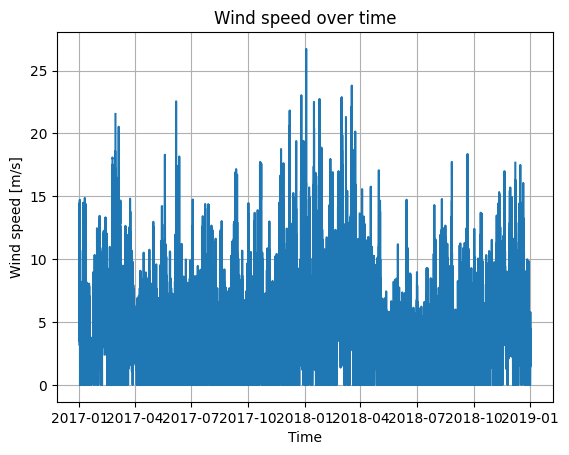

In [8]:
#plot windsnelheid tov van tijd
import matplotlib.pyplot as plt

plt.plot(synced_df.index, synced_df['Avg Wind Speed [km/h] (WeatherStation)'])
plt.xlabel('Time')
plt.ylabel('Wind speed [m/s]')
plt.title('Wind speed over time')
plt.grid()
plt.show()

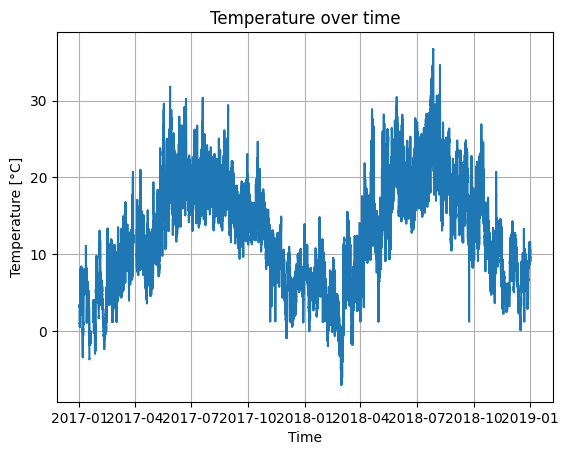

In [9]:
#plot temperature tov van tijd

plt.plot(synced_df.index, synced_df['Avg Air Temperature (WeatherStation)'])
plt.xlabel('Time')
plt.ylabel('Temperature [°C]')
plt.title('Temperature over time')
plt.grid()
plt.show()

In [9]:
import pvlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pvlib.location import Location
from pvlib.modelchain import ModelChain



def simulate_pv_with_real_data(
    df,
    location_name="AMOLF",
    latitude=52.356025,
    longitude=4.949089,
    timezone="Europe/Amsterdam",
    surface_tilt=45, #uit de foto
    surface_azimuth=180,
    module_name="Canadian_Solar_CS5P_220M___2009_",
    inverter_name="ABB__MICRO_0_25_I_OUTD_US_208__208V_"
):
    """
    Simuleer een PV-systeem met eigen (realtime) meetdata en retourneer de resultaten.
    """

    # 2. Locatie
    location = Location(latitude=latitude, longitude=longitude, tz=timezone, name=location_name)

    # 3. Weather DataFrame
    weather = pd.DataFrame(index=df.index)
    if "Avg Air Temperature (WeatherStation)" in df.columns:
        weather["temp_air"] = df["Avg Air Temperature (WeatherStation)"]
    else:
        weather["temp_air"] = 20.0
    if "Avg Wind Speed [km/h] (WeatherStation)" in df.columns:
        weather["wind_speed"] = df["Avg Wind Speed [km/h] (WeatherStation)"] / 3.6
    else:
        weather["wind_speed"] = 1.0
    if "G_pyranometer[W/mï½²]_3 (Solarpanel parameters)" in df.columns:
        weather["ghi"] = df["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"]
    else:
        raise ValueError("Kolom GHI niet gevonden")

    # 4. Schat DNI en DHI
    solar_position = location.get_solarposition(weather.index)
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    pressure = 101325  # [Pa]

    weather["dni"] = pvlib.irradiance.dirint(
        weather["ghi"],
        solar_position["zenith"],   # of "apparent_zenith"
        weather.index,
        dni_extra,
        pressure,
        True  # = use_delta_kt
    )
    weather["dhi"] = weather["ghi"] - weather["dni"] * np.cos(
        np.radians(solar_position["zenith"])
    )

    # 5. Ophalen module- en inverterparameters
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
    if module_name not in sandia_modules.columns:
        raise ValueError(f"Module '{module_name}' niet gevonden in SandiaMod-database.")
    if inverter_name not in cec_inverters.columns:
        raise ValueError(f"Inverter '{inverter_name}' niet gevonden in cecinverter-database.")

    module = sandia_modules[module_name]
    inverter = cec_inverters[inverter_name]

    # 6. PVSystem met module_type en racking_model
    system = pvlib.pvsystem.PVSystem(
        surface_tilt=surface_tilt,
        surface_azimuth=surface_azimuth,
        module_parameters=module,
        inverter_parameters=inverter,
        module_type="glass_polymer",  
        racking_model="open_rack"
    )

    # 7. ModelChain
    mc = ModelChain(system, location)

    # 8. Run model
    mc.run_model(weather)
    ac_power = mc.results.ac  # W

    # 9. Energie bepalen (5-min resolutie)
    dt_hours = (ac_power.index.to_series().diff().dt.total_seconds() / 3600).fillna(0)
    energy_per_timestep = (ac_power / 1000) * dt_hours  # kWh
    cumulative_energy = energy_per_timestep.cumsum()
    total_energy_kwh = energy_per_timestep.sum()

    results = pd.DataFrame({
        "ac_power": ac_power,
        "cumulative_energy": cumulative_energy
    })

    return results, total_energy_kwh

In [10]:
results, total_kWh = simulate_pv_with_real_data(
    synced_df,
    location_name="Amsterdam",
    latitude=52.3676,
    longitude=4.9041,
    timezone="Europe/Amsterdam",
    surface_tilt=30,
    surface_azimuth=180
)

                     ac_power  cumulative_energy
datetime                                        
2017-01-01 00:00:00       NaN                NaN
2017-01-01 00:05:00       NaN                NaN
2017-01-01 00:10:00       NaN                NaN
2017-01-01 00:15:00       NaN                NaN
2017-01-01 00:20:00       NaN                NaN
Totale energie-opbrengst: 406.81 kWh


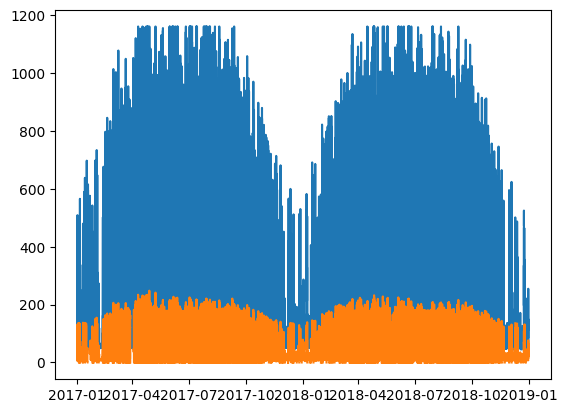

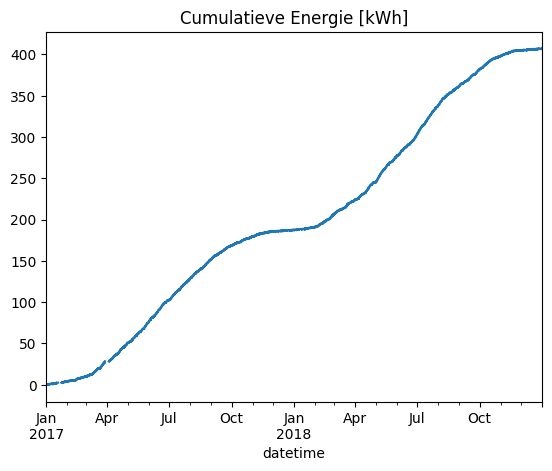

In [11]:
print(results.head())
print(f"Totale energie-opbrengst: {total_kWh:.2f} kWh")

#plot G[W/mï½²]_3 (Solarpanel parameters) tov van tijd
plt.plot(synced_df.index,synced_df["G[W/mï½²]_3 (Solarpanel parameters)"])
plt.plot(results["ac_power"])
plt.show()

#plot cum energie G[W/mï½²]_3 (Solarpanel parameters) tov van de tijd
results["cumulative_energy"].plot(title="Cumulatieve Energie [kWh]")
plt.show()

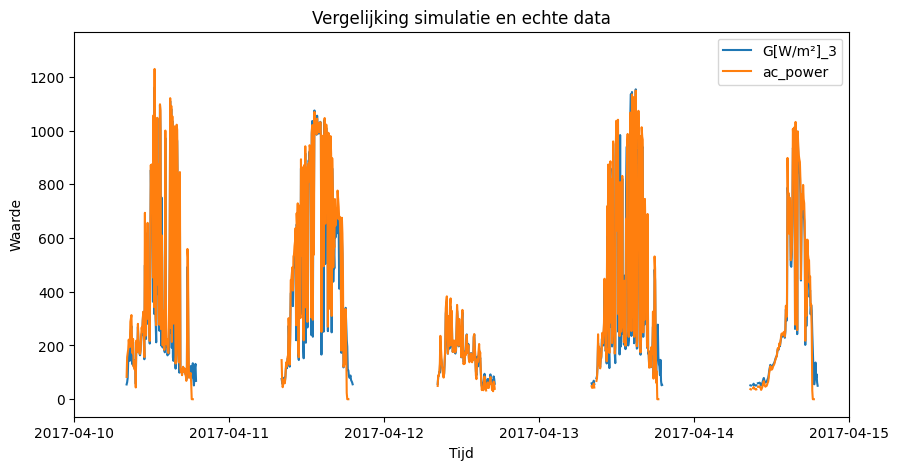

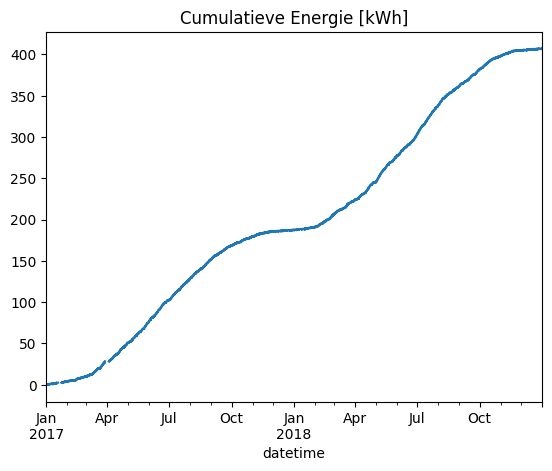

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 3) Plot G[W/m²]_3 vs. ac_power
plt.figure(figsize=(10,5))
plt.plot(synced_df.index, synced_df["G[W/mï½²]_3 (Solarpanel parameters)"], label="G[W/m²]_3")
plt.plot(results.index, results["ac_power"], label="ac_power") #keer 5
plt.title("Vergelijking simulatie en echte data")
plt.xlabel("Tijd")
plt.ylabel("Waarde")
plt.legend()
plt.xlim(pd.Timestamp("2017-04-10"), pd.Timestamp("2017-04-15"))
plt.show()

# 4) Cumulatieve energie plot (alleen results)
plt.figure()
results["cumulative_energy"].plot(title="Cumulatieve Energie [kWh]")
plt.show()
